# Introduction, Description
This notebook is dedicated to the development of a pipeline that perform a quality assessment of an eeg signal.
The different metrics will be calculated:
- Average Root Mean Square (RMS) of a sliding window
- Maximum Gradient of a sliding window
- Zero Crossing Rate of a sliding window
- Complexity of the signal (Hjorth's parameters) of a sliding window
- Kurtosis of a sliding window
- Skewness of a sliding window
- Variance of a sliding window
- Range of a sliding window
- Interquartile range of a sliding window
- Signal to Noise Ratio (SNR)
    - Time domain: 
        - ECG based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - TR based epochs (signal = average across epochs, noise = std across epochs) need to be lowered
        - EEG based epochs (signal = average across epochs, noise = std across epochs) need to be increased
    - Frequency domain:
        - Gradient artifacts (signal = peak frequency of the cross-correlation of the non-cleaned signal, noise = average of the n surrounding bins around the peak)
        - Base frequency of the task (signal = amplitude at the base freqeuency, noise = average of the n surrounding bins around the peak)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis as spectrums_package
raw = mne.io.read_raw_edf(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf', 
    preload=True)
spectrum_object = spectrums_package.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

Extracting EDF parameters from /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-06_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156749  =      0.000 ...   626.996 secs...


In [32]:
%matplotlib qt
channel = 1
f_min = 0
f_max = 40
obj = snr
channels = ['ECG']
def get_channel_index(channel_list):
    return [obj.info['ch_names'].index(channel) for channel in channel_list]
def plot_tagging(channels = ['ECG'],
                 f_min = 0,
                 f_max = 40,
                 obj = obj):
    channel_index = get_channel_index(channels)
    
    if len(channels) > 1:
        
    index_f_min = obj._get_frequency_index(f_min) + int( obj.sampling_rate)
    index_f_max = obj._get_frequency_index(f_max)
    magnitude = obj.get_peak_magnitude_in_window((17, 20))
    max_spectrum = np.max(obj.spectrum[channels,index_f_min:index_f_max])
    plt.plot(obj.frequencies[index_f_min:index_f_max], 
            obj.spectrum[channel,index_f_min:index_f_max].T,
            color = 'black',
            alpha = 0.5,
            )
    freq_window = fft.frequencies[magnitude['window_idx'][0]:magnitude['window_idx'][1]]
    plt.fill_between(freq_window, 
                    y1 = 6*max_spectrum, 
                    color='orange', 
                    alpha=0.3, 
                    label="Search Window",
                    )
    plt.axhline(magnitude['peak_magnitude'][channel], 
                color='r', 
                linewidth=1, 
                alpha=0.5, 
                label="Peak Magnitude",
                )
    plt.axvline(magnitude['peak_frequency_Hz'][channel], 
                color='g', 
                linewidth=1, 
                alpha =  0.5, 
                label="Peak Frequency",
                )
    y_min = np.min(obj.spectrum[channel,:])
    y_max = 6*max_spectrum/5
    plt.ylim(y_min, y_max)
    plt.xlim(f_min, f_max)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (V^2/Hz)')
    plt.text(magnitude['peak_frequency_Hz'][channel]+f_max/100, 
            magnitude['peak_magnitude'][channel]+y_max/100,
            f"""{np.round(magnitude['peak_magnitude'][channel],3)}{obj.units} 
    {np.round(magnitude['peak_frequency_Hz'][channel],2)} Hz""",
            fontsize=8)
    plt.legend()

[10659, 12540]


In [36]:
l = [1,2,3,4,5,6,7,8,9,10]
l[3]

4

# Naive implementation
With windowing method using for loops and lists.

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis, time_analysis 
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
spectrum_object = frequency_analysis.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

time_window = 1
overlap = 0.5
data = raw.get_data()
metrics = {
    channel_name:
    {
    'average_rms': list(),
    'max_gradient': list(),
    'zero_crossing_rate': list(),
    'hjorth_mobility': list(),
    'hjorth_complexity': list(),
    'kurtosis': list(),
    'skewness': list(),
    'variance': list(),
    'signal_range': list(),
    'signal_IQR': list(),
    }
    for channel_name in raw.info['ch_names']
    
}
starts = np.arange(0, data.shape[1], int((time_window*raw.info['sfreq']))*overlap)
ends = starts + int((time_window*raw.info['sfreq']))

for channel_nb in range(data.shape[0]):
    for start, end in zip(starts, ends):
        if end > data.shape[1]:
            break
        segment = data[channel_nb, int(start):int(end)]
        ch_name = raw.info['ch_names'][channel_nb]
        for metric in metrics[ch_name]:
            metrics[ch_name][metric].append(getattr(time_analysis, metric)(segment))
        
    metrics[ch_name]['amplitudes'] = amplitude.spectrum[channel_nb, :]
    metrics[ch_name]['snr'] = snr.spectrum[channel_nb, :]
    metrics[ch_name]['zscore'] = zscore.spectrum[channel_nb, :]


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


TypeError: average_rms() missing 1 required positional argument: 'mean_kwargs'

# Optimized implementation
With windowing method using numpy arrays and vectorized operations.

## Sanity check of the sliding window approach

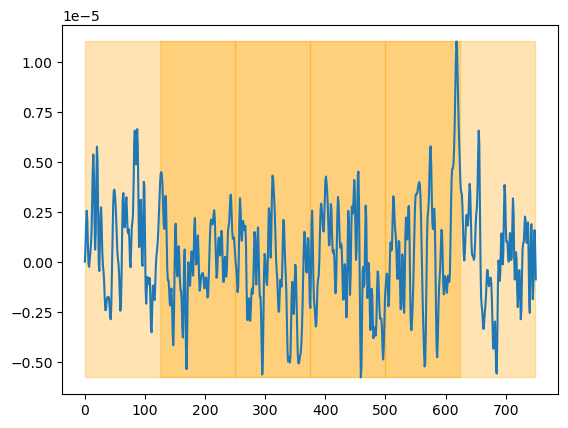

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 1
overlap = 0.5
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(data[chan_nb,:])

for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')

In [2]:
from numpy.lib.stride_tricks import sliding_window_view

import mne
import numpy as np
import matplotlib.pyplot as plt
from EEG_quality_assessment import frequency_analysis, time_analysis 
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
spectrum_object = frequency_analysis.Spectrum()
fft = spectrum_object.calculate_fft(raw)
amplitude = spectrum_object.copy().calculate_amplitude()
amplitude._set_frequency_of_interest(18)
zscore = amplitude.copy().calculate_zscore()
snr = amplitude.copy().calculate_snr()

time_window = 1
overlap = 0.5
data = raw.get_data()
samples = np.arange(0, data.shape[1])
window_nb_samples = int((time_window*raw.info['sfreq']))
step = int(window_nb_samples -window_nb_samples *overlap)
window_view = sliding_window_view(samples , 
                                  window_nb_samples )[::step]

starts = np.arange(0, data.shape[1], int((time_window*raw.info['sfreq']))*overlap)
ends = starts + int((time_window*raw.info['sfreq']))
metrics_name = ['average_rms', 
                'max_gradient',
                'zero_crossing_rate',
                'hjorth_mobility',
                'hjorth_complexity',
                'kurtosis',
                'skewness',
                'variance',
                'signal_range',
                'signal_IQR']

metrics = {name: np.empty(shape = (data.shape[0], window_view.shape[0])) 
           for name in metrics_name}

for window_index in range(window_view.shape[0]):
    windowed_signal = data[:, window_view[window_index,:]]
    for metric in metrics_name:
        metrics[metric][:,window_index] = getattr(
            time_analysis, metric)(windowed_signal)

metrics['amplitudes'] = amplitude.spectrum
metrics['snr'] = snr.spectrum
metrics['zscore'] = zscore.spectrum


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


TypeError: average_rms() missing 1 required positional argument: 'mean_kwargs'

# Full vectorization of the sliding window approach
Trying to get rid of for loops and use only numpy vectorized operations.

## Sanity check of the full vectorization approach
First the time samples windowing is checked.

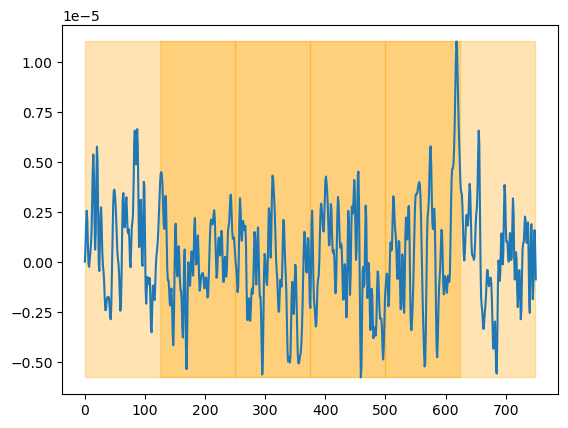

In [3]:
from numpy.lib.stride_tricks import sliding_window_view
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 1
overlap = 0.5
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(data[chan_nb,:])

for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')

Now, check the values of one calculated metric using the time indexing.

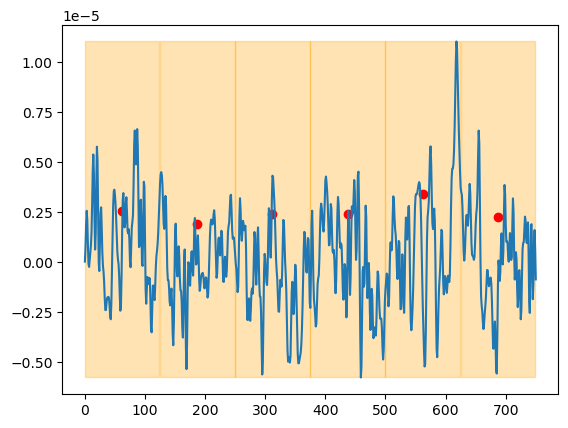

In [2]:
from numpy.lib.stride_tricks import sliding_window_view
from EEG_quality_assessment import time_analysis
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 0.5
overlap = 0
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view = sliding_window_view(time_samples, 
                                  window_samples)[::step]
plt.plot(data[chan_nb,:])

for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(data[:,window_view[jump,:]],
                                          mean_kwargs = {'axis':1})[chan_nb],
                color = 'r')

Check the values of one calculated metric using the vectorization.

In [19]:

from numpy.lib.stride_tricks import sliding_window_view
from EEG_quality_assessment import time_analysis
import mne
import numpy as np
raw = mne.io.read_raw_fif(
    '/Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif', 
    preload=True,
)
channel = 'Fp1'
chan_nb = raw.info['ch_names'].index(channel)
time_window = 0.5
overlap = 0 
copy_raw = raw.copy().crop(0,3)
data = copy_raw.get_data()
time_samples = np.arange(0, data.shape[1])
window_samples = int((time_window*raw.info['sfreq']))
step = int(window_samples - window_samples*overlap)
window_view2 = sliding_window_view(data, 
                                  window_shape = window_samples,
                                  axis = 1)[:,::step,:]
#plt.plot(data[chan_nb,:])
calculation = time_analysis.average_rms(window_view2, mean_kwargs = {'axis': 2})


Opening raw data file /Users/samuel/01_projects/EEG_quality_assessment/tests/sub-04_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.fif...
    Read a total of 7 projection items:
        eeg-Raw-0.000-693.120-PCA-01 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-02 (1 x 61) active
        eeg-Raw-0.000-693.120-PCA-03 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-01 (1 x 61) active
        ECG-eeg--0.200-0.400-PCA-02 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-01 (1 x 61) active
        EOG-eeg--0.200-0.200-PCA-02 (1 x 61) active
    Range : 0 ... 173279 =      0.000 ...   693.116 secs
Ready.
Reading 0 ... 173279  =      0.000 ...   693.116 secs...


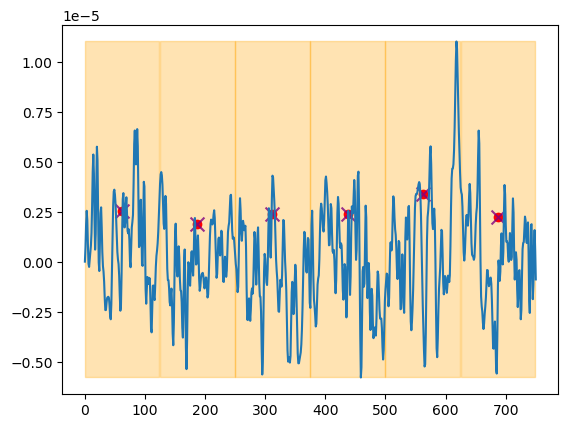

In [28]:
from matplotlib import pyplot as plt
plt.plot(data[chan_nb,:])
for jump in range(window_view2.shape[1]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(
                    data[:,window_view[jump,:]],
                    mean_kwargs = {'axis':1}
                    )[chan_nb],
                color = 'r')
plt.scatter(window_view[:,window_view.shape[1]//2],calculation[chan_nb,:], 
            color = 'purple',
            marker='x',
            s = 100,
            alpha = 0.8)

array([ 62, 187, 312, 437, 562, 687])

In [18]:
calculation[chan_nb,:]

array([2.24218550e-06, 2.40211152e-06, 2.88332649e-06])

In [12]:
500/64

7.8125

In [ ]:
for jump in range(window_view.shape[0]):
    plt.fill_between(window_view[jump,:], 
                     y1 = np.min(data[chan_nb,:]), 
                     y2 = np.max(data[chan_nb,:]), 
                     alpha = 0.3, 
                     color = 'orange')
    plt.scatter(window_view[jump,window_view.shape[1]//2],
                time_analysis.average_rms(data[:,window_view[jump,:]])[chan_nb],
                color = 'r')

In [2]:
metrics['variance'].shape

(64, 1385)

In [130]:
window_view.shape

(5, 250)

In [90]:
raw.info.keys()

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])

- sfreq
- highpass
- lowpass
- chs
- line_freq
- bads
- ch_names

In [75]:
raw.set_channel_types({'ECG':'ecg'})

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [82]:
ECG_epochs = mne.preprocessing.create_ecg_epochs(raw)

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 650 (average pulse 58 / min.)
Not setting metadata
650 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Using data from preloaded Raw for 650 events and 251 original time points ...
3 bad epochs dropped


In [86]:
raw.ch_names.index('ECG')

31

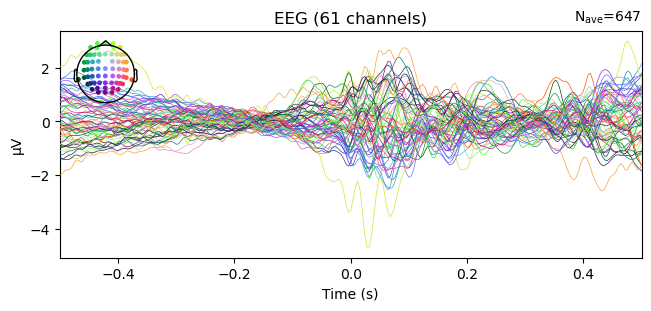

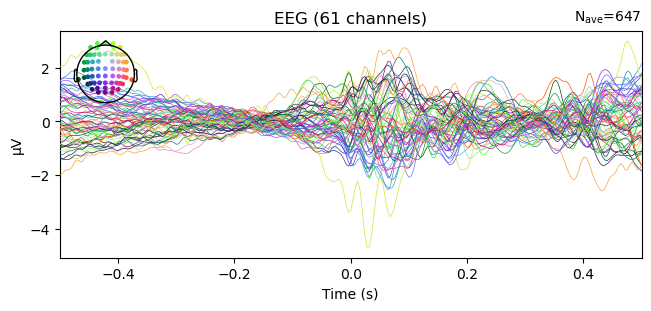

In [88]:
ECG_epochs.copy().average().plot()

In [70]:
ECG_events = mne.preprocessing.find_ecg_events(raw)
mne.annotations_from_events(ECG_events[0], raw.info['sfreq'])

Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 823 (average pulse 78 / min.)


<Annotations | 823 segments: 999 (823)>

In [71]:
raw.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none
Attempting to create new mne-python configuration file:
/Users/samuel/.mne/mne-python.json


In [17]:
metrics[str(raw.info['ch_names'][channel_nb])][metric].append(getattr(time_analysis, metric)(segment))

KeyError: 'Fp1'

In [30]:
raw.info['ch_names'][channel_nb].encode('utf-8').decode('utf-8')

'Fp1'

In [16]:
test = {'a': {'e':1}, 'b': 2}
l = ['a', 'b', 'e']
test[l[0]]

1

In [11]:
metrics['Fp1']

{'average_rms': [],
 'max_gradient': [],
 'zero_crossing_rate': [],
 'hjorth_mobility': [],
 'hjorth_complexity': [],
 'kurtosis': [],
 'skewness': [],
 'variance': [],
 'signal_range': [],
 'signal_IQR': []}

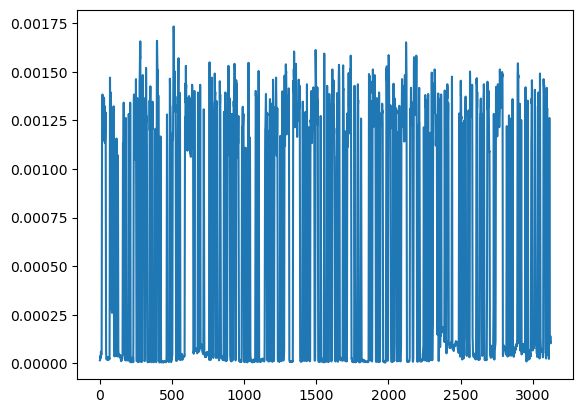

In [63]:
import matplotlib.pyplot as plt
plt.plot(metrics['Fp2']['signal_IQR'])

In [2]:
str(half_spectrum.dtype)

NameError: name 'half_spectrum' is not defined

In [1]:
from EEG_quality_assessment import frequency_analysis as spectrums_package

In [7]:
t = __import__('frequency_spectrums')

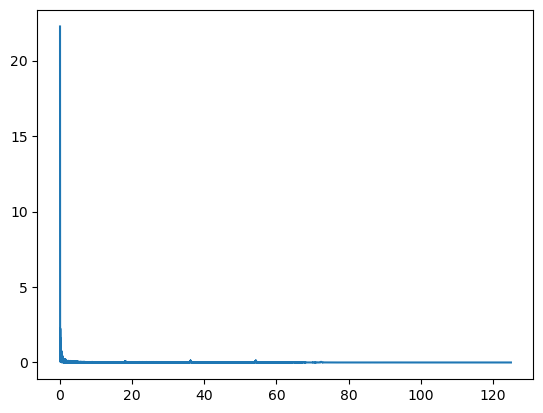

In [34]:
import matplotlib.pyplot as plt
plt.plot(frequencies,np.abs(half_spectrum[0,:]))

In [1]:
a = 'string'
type(a) == str

True